In [1]:
suppressMessages(library(phyloseq))
suppressMessages(library(vegan))
suppressMessages(library(repr))
suppressMessages(library(ggplot2))
suppressMessages(library(SoDA))
suppressMessages(library(adespatial))
suppressMessages(library(ggmap))

In [2]:
#Taxonomy of each OTU
tax = read.delim("../otu_data/dada2_outputs/taxa_table_with_OTUs.txt", row.names=1)
tax_mat = as.matrix(tax)
colnames(tax_mat)[1] <- 'Domain'
tax_mat[tax_mat == ""] <- NA

In [3]:
#Probe & USGS Discharge Data
env_data_file = "/Volumes/KeithSSD/CB_V4/otu_data/WaterQualityData/matched_cleaned_data/all_mdata_with_habitat.txt"
env_data <- read.delim(env_data_file, row.names=1)

env_data$Year <- factor(env_data$Year)
env_data$Month <- factor(env_data$Month)
env_data$habitat <- factor(env_data$habitat)
print(colnames(env_data))

 [1] "StationName"              "depth_float"             
 [3] "Latitude"                 "Longitude"               
 [5] "RawCount"                 "TrimCount"               
 [7] "CollectionAgency"         "sequencing_ID"           
 [9] "Month"                    "Year"                    
[11] "Month_Year"               "julian_day"              
[13] "day_length"               "anti_day_length"         
[15] "julian_seconds"           "Depth_Percentage"        
[17] "Discharge_James_14"       "Discharge_Susquehanna_14"
[19] "enspie"                   "faith_pd"                
[21] "WTEMP"                    "SALINITY"                
[23] "DO"                       "PH"                      
[25] "habitat"                  "AC_PrinComp2"            


In [4]:
# Chesapeake Bay Foundation Data 
transect_data_f = "../otu_data/WaterQualityData/matched_cleaned_data/transect_mdata_colset_1.tsv"
tran_df <- read.delim(transect_data_f, row.names=1)
missing_columns = setdiff(colnames(tran_df), colnames(env_data))
print(missing_columns)
for (i in missing_columns){
    env_data[,i] <- NA
    env_data[rownames(tran_df),i] = tran_df[rownames(tran_df), i]
}

 [1] "TON"     "TP"      "TN"      "PN"      "PP"      "PC"      "TSS"    
 [8] "NO2F"    "DON"     "DIN"     "NH4F"    "NO23F"   "DOP"     "CHLA"   
[15] "NO3F"    "PHEO"    "PO4F"    "TDN"     "TDP"     "SIGMA_T" "SPCOND" 


In [5]:
# SalZone
env_data[,'SalZone'] <- NA
oligohaline <- c('CB22', 'CB31')
mesohaline <- c('CB32', 'CB33C', 'CB41C', 'CB42C', 'CB43C', 'CB44', 'CB51', 'CB52', 'CB53', 'CB54')
polyhaline <- c('CB61', 'CB62', 'CB63', 'CB64', 'CB71', 'CB72', 'CB73', 'CB74')
env_data[which(env_data[,'StationName'] %in% oligohaline),'SalZone'] <- '1_oligohaline'
env_data[which(env_data[,'StationName'] %in% mesohaline),'SalZone'] <- '2_mesohaline'
env_data[which(env_data[,'StationName'] %in% polyhaline),'SalZone'] <- '3_polyhaline'
env_data$SalZone <- factor(env_data$SalZone)
table(env_data$SalZone)


1_oligohaline  2_mesohaline  3_polyhaline 
           18           185            87 

In [6]:
our_station = env_data[,'StationName'] == 'CB33C' 
env_data[,'depth_segment'] <- NA
env_data[which((!our_station) & env_data$depth_float > 2), 'depth_segment'] = 'Bottom'
env_data[which(env_data$depth_float < 2), 'depth_segment'] = 'Top'
env_data[which(our_station & env_data$depth_float > 11), 'depth_segment'] = 'Bottom'
env_data[is.na(env_data[,'depth_segment']),'depth_segment'] = 'Mid'
env_data[,'depth_segment'] = factor(env_data[,'depth_segment'], levels=c('Top', 'Mid', 'Bottom'))
table(env_data$depth_segment)


   Top    Mid Bottom 
    67     46    177 

In [7]:
# StatName
env_data[,'StatName'] <- NA
statg1 = c('CB22', 'CB31', 'CB32')
statg2 = c('CB33C', 'CB41C')
statg3 = c('CB42C', 'CB43C', 'CB44', 'CB51')
statg4 = c('CB52', 'CB53', 'CB54', 'CB71')
statg5 = c('CB61', 'CB62', 'CB63', 'CB64')
statg6 = c('CB72', 'CB73', 'CB74')

env_data[which(env_data[,'StationName'] %in% statg1),'StatName'] <- '1'
env_data[which(env_data[,'StationName'] %in% statg2),'StatName'] <- '2'
env_data[which(env_data[,'StationName'] %in% statg3),'StatName'] <- '3'
env_data[which(env_data[,'StationName'] %in% statg4),'StatName'] <- '4'
env_data[which(env_data[,'StationName'] %in% statg5),'StatName'] <- '5'
env_data[which(env_data[,'StationName'] %in% statg6),'StatName'] <- '6'

env_data$StatName <- factor(env_data$StatName)
print(sum(is.na(env_data[,'StatName'])))
table(env_data$StatName)

[1] 0



  1   2   3   4   5   6 
 25 103  43  47  45  27 

In [8]:
select_cols = c('StatName', 'Year', 'Month', 'Discharge_Susquehanna_14', 'Latitude', 'Longitude',
                'depth_segment', 'habitat', 'enspie', 'faith_pd', 'day_length', 'CollectionAgency', 
                'anti_day_length', 'WTEMP', 'SALINITY', 'DO', 'DOP', 'NO2F', 'PC', 'PHEO', 'NO3F', 
                'NH4F', 'TP', 'CHLA', 'TDN', 'SalZone', 'AC_PrinComp2', 'depth_float', 
                'TrimCount', 'Month_Year', 'PH', 'julian_day')

maxi_set = select_cols[colSums(is.na(env_data[,select_cols])) == 0]
print(maxi_set)
ENV.maxi = env_data[,maxi_set]
dim(ENV.maxi)
sum(colSums(is.na(ENV.maxi)))

ENV.mini = env_data[!is.na(env_data$DOP), select_cols]
dim(ENV.mini)
sum(colSums(is.na(ENV.mini)))

 [1] "StatName"                 "Year"                    
 [3] "Month"                    "Discharge_Susquehanna_14"
 [5] "Latitude"                 "Longitude"               
 [7] "depth_segment"            "habitat"                 
 [9] "enspie"                   "faith_pd"                
[11] "day_length"               "CollectionAgency"        
[13] "anti_day_length"          "WTEMP"                   
[15] "SALINITY"                 "DO"                      
[17] "SalZone"                  "AC_PrinComp2"            
[19] "depth_float"              "TrimCount"               
[21] "Month_Year"               "PH"                      
[23] "julian_day"              


[1] 290  23

[1] 0

[1] 180  32

[1] 0

In [9]:
#OTU table (shared file)
OTU = read.delim("../otu_data/final_rarefied_table.tsv", row.names=1)
OTU.clean1 = OTU[rownames(env_data), ]
OTU.clean = as.matrix(OTU.clean1[,colSums(OTU.clean1) > 0])
print(dim(OTU.clean))
tax.clean = tax_mat[colnames(OTU.clean), ]
head(tax.clean)

[1]  290 1558


,Domain,Phylum,Class,Order,Family,Genus,Species
OTU1,Bacteria,Cyanobacteria,Oxyphotobacteria,Synechococcales,Cyanobiaceae,Cyanobium_PCC-6307,NA
OTU2,Bacteria,Proteobacteria,Gammaproteobacteria,Ectothiorhodospirales,Ectothiorhodospiraceae,NA,NA
OTU3,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Microbacteriaceae,ML602J-51,NA
OTU4,Bacteria,Actinobacteria,Acidimicrobiia,Microtrichales,Ilumatobacteraceae,NA,NA
OTU5,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Microbacteriaceae,Candidatus_Aquiluna,NA
OTU7,Bacteria,Actinobacteria,Acidimicrobiia,Microtrichales,Ilumatobacteraceae,CL500-29_marine_group,NA


In [10]:
tree_file = "../otu_data/tree_data/not_full_tree/RAxML_rootedTree.root.query_high_abund.ref.tre"
tree_obj = read_tree(tree_file, errorIfNULL=T)
tree.clean = prune_taxa(taxa=colnames(OTU.clean), tree_obj)

In [11]:
OTU.phylo = otu_table(OTU.clean, taxa_are_rows = FALSE)
TAX.phylo = tax_table(tax.clean)
physeq2 = phyloseq(OTU.phylo, TAX.phylo, ENV.maxi, tree.clean)
physeq2

Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘RNeXML’
Found more than one class "phylo" in cache; using the first, from namespace 'phyloseq'
Also defined by ‘

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1558 taxa and 290 samples ]
tax_table()   Taxonomy Table:    [ 1558 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1558 tips and 1557 internal nodes ]

In [12]:
uwunifrac_dist = phyloseq::distance(physeq2, method="unifrac", weighted=F)
wunifrac_dist = phyloseq::distance(physeq2, method="unifrac", weighted=T)

In [13]:
sub_wUF = as.dist(as.matrix(wunifrac_dist)[rownames(ENV.mini), rownames(ENV.mini)])

In [18]:
subm <- env_data[,c("Longitude", "Latitude", "StationName")]
aggSub <- aggregate(.~ StationName, subm, FUN=mean)

In [19]:
cart_coords = as.data.frame(geoXY(latitude=aggSub$Latitude, longitude=aggSub$Longitude, unit=1000))
rownames(cart_coords) <- aggSub$StationName

ENV.maxi[,'Xcoord'] <- NA; ENV.mini[,'Xcoord'] <- NA; 
ENV.maxi[,'Ycoord'] <- NA; ENV.mini[,'Ycoord'] <- NA;

for (stat_ in rownames(cart_coords)){
    stat_ind1 = rownames(ENV.maxi)[env_data$StationName == stat_]
    ENV.maxi[stat_ind1, "Xcoord"] <- cart_coords[stat_, 'X']
    ENV.maxi[stat_ind1, "Ycoord"] <- cart_coords[stat_, 'Y']
    stat_ind2 = intersect(stat_ind1, rownames(ENV.mini))
    ENV.mini[stat_ind2, "Xcoord"] <- cart_coords[stat_, 'X']
    ENV.mini[stat_ind2, "Ycoord"] <- cart_coords[stat_, 'Y']
}

cb.dbmem.maxi <- dbmem(ENV.maxi[,c('Xcoord', 'Ycoord')], thresh = 50.0 ,silent = FALSE)
cb.dbmem.mini <- dbmem(ENV.mini[,c('Xcoord', 'Ycoord')], thresh = 50.0 ,silent = FALSE)

User-provided truncation threshold = 50 
Time to compute dbMEMs = 0.262000  sec 
User-provided truncation threshold = 50 
Time to compute dbMEMs = 0.121000  sec 


In [18]:
#ENV.maxi.2 <- subset(ENV.maxi, select=-c(Xcoord, Ycoord, Month_Year, CollectionAgency, Longitude,
#                                         TrimCount, SalZone, habitat, depth_float, depth_segment))
#
#cap.env.maxi <- capscale(OTU.maxi ~ ., data=ENV.maxi.2, distance='bray')
#mod0.env.maxi <- capscale(OTU.maxi ~ 1, data=ENV.maxi.2, distance='bray')
#step.env.maxi <- ordiR2step(mod0.env.maxi, scope=formula(cap.env.maxi), direction ="forward", 
#                            permutations = how(nperm = 99), trace = TRUE, R2permutations = 299)


In [19]:
#cap.env.maxi.2.uf <- capscale(wunifrac_dist ~ ., data=ENV.maxi.2)
#mod0.env.maxi.2.uf <- capscale(wunifrac_dist ~ 1, data=ENV.maxi.2)
#
#step.env.maxi.2.uf <- ordiR2step(mod0.env.maxi.2.uf, scope=formula(cap.env.maxi.2.uf), direction ="forward", 
#                            permutations = how(nperm = 99), trace = TRUE, R2permutations = 299)


In [34]:
#OTU.maxi = OTU.clean[rownames(ENV.maxi),]
#cap.pcnm.maxi <- capscale(OTU.maxi ~ ., data=as.data.frame(scores(cb.dbmem.maxi)), distance='bray')
#mod0.pcnm.maxi <- capscale(OTU.maxi ~ 1, data=as.data.frame(scores(cb.dbmem.maxi)), distance='bray')
#step.pcnm.maxi <- ordistep(mod0.pcnm.maxi, scope=formula(cap.pcnm.maxi), trace=F)
#step.pcnm.maxi

[1] "tot.chi"   "Ybar"      "method"    "call"      "pCCA"      "CCA"      
 [7] "CA"        "vdata"     "colsum"    "terms"     "terminfo"  "sqrt.dist"
[13] "adjust"    "inertia"   "anova"

In [48]:
OTU.mini = OTU.clean[rownames(ENV.mini),]

cap.pcnm.mini <- capscale(OTU.mini ~ ., data=as.data.frame(scores(cb.dbmem.mini)), distance='bray')
mod0.pcnm.mini <- capscale(OTU.mini ~ 1, data=as.data.frame(scores(cb.dbmem.mini)), distance='bray')
step.pcnm.mini <- ordistep(mod0.pcnm.mini, scope=formula(cap.pcnm.mini), trace=F)
anova(step.pcnm.mini)

,Df,SumOfSqs,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,3,6.174761,8.315723,0.001
Residual,176,43.562375,NA,NA


In [20]:
ENV.mini.x <- subset(ENV.mini, select=-c(Xcoord, Ycoord, Month_Year, CollectionAgency, Longitude, 
                                         TrimCount, AC_PrinComp2, habitat, depth_segment, Month, StatName,
                                         SalZone, Year))
ENV.mini.2 <- cbind.data.frame(ENV.mini.x, as.data.frame(scores(cb.dbmem.mini)))

ENV.mini.2[1:3, 1:3]

,Discharge_Susquehanna_14,Latitude,enspie
,<dbl>,<dbl>,<dbl>
SB071116TAWCSCB22D11BR2TR2I616,93274.58,39.34873,39.20869
SB071116TAWCSCB33CD24BR1TR2I611,95166.88,38.99596,69.40346
SB071116TAWCSCB43CD26BR1TR1I151,95166.88,38.55505,47.41473


In [51]:
cap.env.mini <- capscale(OTU.mini ~ ., data=ENV.mini.2, distance='bray')
mod0.env.mini <- capscale(OTU.mini ~ 1, data=ENV.mini.2, distance='bray')
step.env.mini <- ordiR2step(mod0.env.mini, scope=formula(cap.env.mini), direction ="forward", 
                            permutations = how(nperm = 199), trace = TRUE, R2permutations = 599,
                            steps=length(select_cols)-5)


Step: R2.adj= 0 
Call: OTU.mini ~ 1 
 
                           R2.adjusted
<All variables>            0.624652435
+ anti_day_length          0.248360856
+ WTEMP                    0.223599133
+ Discharge_Susquehanna_14 0.210972078
+ faith_pd                 0.170129529
+ SALINITY                 0.102660996
+ TP                       0.094528719
+ Latitude                 0.087062037
+ enspie                   0.076110506
+ DO                       0.069145459
+ DOP                      0.068231817
+ TDN                      0.065606068
+ MEM1                     0.061589613
+ day_length               0.054418851
+ NO3F                     0.049813887
+ PC                       0.043071962
+ PH                       0.040943569
+ depth_float              0.039709369
+ NH4F                     0.034861883
+ MEM2                     0.033935621
+ CHLA                     0.032359696
+ PHEO                     0.030269215
+ NO2F                     0.029112409
+ julian_day             

In [52]:
cap.env.mini.2.uf <- capscale(sub_wUF ~ ., data=ENV.mini.2)
mod0.env.mini.2.uf <- capscale(sub_wUF ~ 1, data=ENV.mini.2)
step.env.mini.2.uf <- ordiR2step(mod0.env.mini.2.uf, scope=formula(cap.env.mini.2.uf), direction ="forward", 
                            permutations = how(nperm = 199), trace = TRUE, R2permutations = 599)

Step: R2.adj= 0 
Call: sub_wUF ~ 1 
 
                           R2.adjusted
<All variables>            0.675353431
+ WTEMP                    0.216516577
+ anti_day_length          0.202862172
+ Discharge_Susquehanna_14 0.185292776
+ faith_pd                 0.177070721
+ TP                       0.123652860
+ DO                       0.119179747
+ DOP                      0.101862475
+ SALINITY                 0.101352636
+ depth_float              0.099288492
+ Latitude                 0.090374969
+ PH                       0.089337882
+ CHLA                     0.083191166
+ TDN                      0.080630428
+ MEM1                     0.073386611
+ NO3F                     0.059448333
+ PC                       0.058715362
+ NH4F                     0.056333174
+ enspie                   0.055287504
+ NO2F                     0.043393683
+ day_length               0.032169318
+ julian_day               0.029665601
+ MEM2                     0.029489761
+ PHEO                    

In [ ]:
dim(ENV.mini.2)
colnames(ENV.mini.2)

In [53]:
# bray ~ anti_day_length + SALINITY + TP + day_length + NO3F + DO
bc_opt_vars = c('anti_day_length', 'SALINITY', 'TP', 'day_length', 'NO3F', 'DO')

cons_ord_res = data.frame('wuf.adjr2'=c(), 'wuf.pval'=c(), 'wuf.constr'=c(), 
                          'bc.adjr2'=c(), 'bc.pval'=c(), 'bc.constr'=c())

cons_ord_res['full', 'bc.adjr2']  <- RsquareAdj(cap.env.mini)$adj.r.squared
cons_ord_res['full', 'bc.pval']  <- anova(cap.env.mini)["Pr(>F)"]['Model',]
cons_ord_res['full', 'bc.constr']  <- summary(cap.env.mini)$constr.chi/summary(cap.env.mini)$tot.chi

cons_ord_res['full', 'wuf.adjr2']  <- RsquareAdj(cap.env.mini.2.uf)$adj.r.squared
cons_ord_res['full', 'wuf.pval']  <- anova(cap.env.mini.2.uf)["Pr(>F)"]['Model',]
cons_ord_res['full', 'wuf.constr']  <- summary(cap.env.mini.2.uf)$constr.chi/summary(cap.env.mini.2.uf)$tot.chi

for (ind_var in bc_opt_vars){
    cap.env.ind <- capscale(OTU.mini ~ ENV.mini.2[,ind_var], distance='bray')
    cons_ord_res[ind_var, 'bc.adjr2'] = RsquareAdj(cap.env.ind)$adj.r.squared
    cons_ord_res[ind_var, 'bc.pval'] = anova(cap.env.ind)["Pr(>F)"]['Model',]
    cons_ord_res[ind_var, 'bc.constr']  <- summary(cap.env.ind)$constr.chi/summary(cap.env.ind)$tot.chi
}

cap.env.mini.opt <- capscale(OTU.mini ~., data=ENV.mini.2[,bc_opt_vars], distance='bray')
cons_ord_res['best', 'bc.adjr2']  <- RsquareAdj(cap.env.mini.opt)$adj.r.squared
cons_ord_res['best', 'bc.pval']  <- anova(cap.env.mini.opt)["Pr(>F)"]['Model',]
cons_ord_res['best', 'bc.constr']  <- summary(cap.env.mini.opt)$constr.chi/summary(cap.env.mini.opt)$tot.chi

# sub_wUF ~ WTEMP + DO + SALINITY + TP + julian_day + NO3F + day_length
wuf_opt_vars = c("WTEMP", "DO", "SALINITY", "TP", "julian_day", "NO3F", "day_length")

for (ind_var in wuf_opt_vars){
    cap.env.ind <- capscale(sub_wUF ~ ENV.mini.2[,ind_var])
    cons_ord_res[ind_var, 'wuf.adjr2'] = RsquareAdj(cap.env.ind)$adj.r.squared
    cons_ord_res[ind_var, 'wuf.pval'] = anova(cap.env.ind)["Pr(>F)"]['Model',]
    cons_ord_res[ind_var, 'wuf.constr']  <- summary(cap.env.ind)$constr.chi/summary(cap.env.ind)$tot.chi
}

cap.env.mini.opt <- capscale(sub_wUF ~., data=ENV.mini.2[,wuf_opt_vars])
cons_ord_res['best', 'wuf.adjr2']  <- RsquareAdj(cap.env.mini.opt)$adj.r.squared
cons_ord_res['best', 'wuf.pval']  <- anova(cap.env.mini.opt)["Pr(>F)"]['Model',]
cons_ord_res['best', 'wuf.constr']  <- summary(cap.env.mini.opt)$constr.chi/summary(cap.env.mini.opt)$tot.chi

all_opt = unique(c(bc_opt_vars, wuf_opt_vars))
round(cons_ord_res[c(all_opt, 'best', 'full'),], 3)

,bc.adjr2,bc.pval,bc.constr,wuf.adjr2,wuf.pval,wuf.constr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
anti_day_length,0.248,0.001,0.248,NA,NA,NA
SALINITY,0.103,0.001,0.106,0.101,0.001,0.096
TP,0.095,0.001,0.098,0.124,0.001,0.116
day_length,0.054,0.001,0.059,0.032,0.001,0.034
NO3F,0.050,0.001,0.054,0.059,0.001,0.058
DO,0.069,0.001,0.073,0.119,0.001,0.112
WTEMP,NA,NA,NA,0.217,0.001,0.200
julian_day,NA,NA,NA,0.030,0.001,0.032
best,0.496,0.001,0.504,0.553,0.001,0.516



Partition of variance in RDA 

Call: varpart(Y = OTU.mini, X = ~anti_day_length, ~day_length +
julian_day, ~TP + NO3F + DO, ~SALINITY, data = ENV.mini)

Explanatory tables:
X1:  ~anti_day_length
X2:  ~day_length + julian_day
X3:  ~TP + NO3F + DO
X4:  ~SALINITY 

No. of explanatory tables: 4 
Total variation (SS): 27869408 
            Variance: 155695 
No. of observations: 180 

Partition table:
                            Df R.square Adj.R.square Testable
[aeghklno] = X1              1  0.18979      0.18524     TRUE
[befiklmo] = X2              2  0.05922      0.04859     TRUE
[cfgjlmno] = X3              3  0.18086      0.16690     TRUE
[dhijkmno] = X4              1  0.07128      0.06606     TRUE
[abefghiklmno] = X1+X2       3  0.25009      0.23731     TRUE
[acefghjklmno] = X1+X3       4  0.33681      0.32165     TRUE
[adeghijklmno] = X1+X4       2  0.26459      0.25628     TRUE
[bcefgijklmno] = X2+X3       5  0.24034      0.21851     TRUE
[bdefhijklmno] = X2+X4       3  0.12289   


Partition of variance in RDA 

Call: varpart(Y = OTU.mini, X = ~WTEMP, ~day_length + julian_day, ~TP +
NO3F + PHEO + DO, ~SALINITY, data = ENV.mini)

Explanatory tables:
X1:  ~WTEMP
X2:  ~day_length + julian_day
X3:  ~TP + NO3F + PHEO + DO
X4:  ~SALINITY 

No. of explanatory tables: 4 
Total variation (SS): 27869408 
            Variance: 155695 
No. of observations: 180 

Partition table:
                            Df R.square Adj.R.square Testable
[aeghklno] = X1              1  0.18060      0.17600     TRUE
[befiklmo] = X2              2  0.05922      0.04859     TRUE
[cfgjlmno] = X3              4  0.20649      0.18835     TRUE
[dhijkmno] = X4              1  0.07128      0.06606     TRUE
[abefghiklmno] = X1+X2       3  0.24389      0.23100     TRUE
[acefghjklmno] = X1+X3       5  0.35932      0.34090     TRUE
[adeghijklmno] = X1+X4       2  0.25271      0.24426     TRUE
[bcefgijklmno] = X2+X3       6  0.26598      0.24053     TRUE
[bdefhijklmno] = X2+X4       3  0.12289      0.1

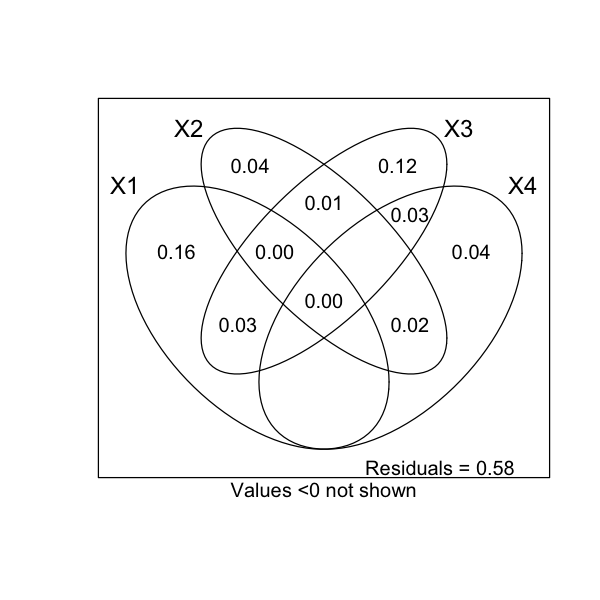


Partition of variance in RDA 

Call: varpart(Y = OTU.mini, X = ~WTEMP, ~anti_day_length, data =
ENV.mini)

Explanatory tables:
X1:  ~WTEMP
X2:  ~anti_day_length 

No. of explanatory tables: 2 
Total variation (SS): 27869408 
            Variance: 155695 
No. of observations: 180 

Partition table:
                     Df R.squared Adj.R.squared Testable
[a+b] = X1            1   0.18060       0.17600     TRUE
[b+c] = X2            1   0.18979       0.18524     TRUE
[a+b+c] = X1+X2       2   0.23429       0.22563     TRUE
Individual fractions                                    
[a] = X1|X2           1                 0.04039     TRUE
[b]                   0                 0.13560    FALSE
[c] = X2|X1           1                 0.04964     TRUE
[d] = Residuals                         0.77437    FALSE
---
Use function ‘rda’ to test significance of fractions of interest

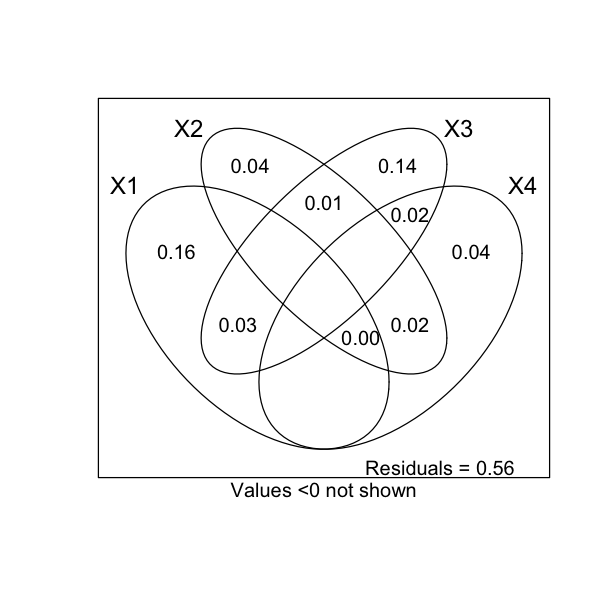

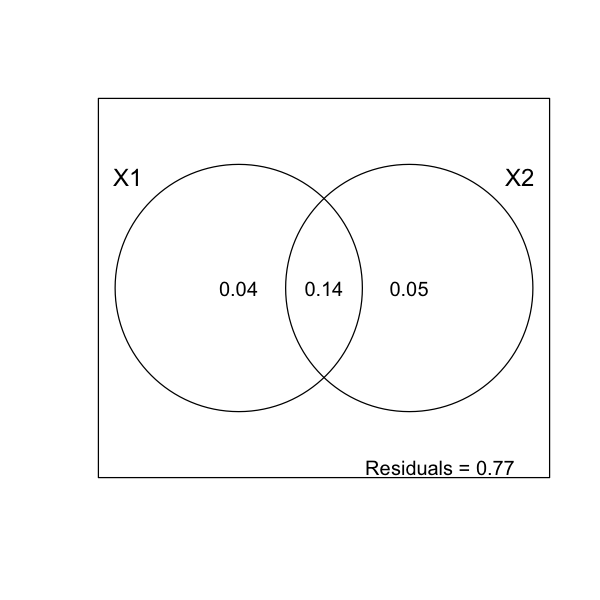

In [65]:
options(repr.plot.width=5, repr.plot.height=5)

cb.spatial.mini <- scores(cb.dbmem.mini, choices=c(1:3))

cb.varpart.mini <- varpart(OTU.mini, 
                           ~ anti_day_length,
                           ~ day_length + julian_day,
                           ~ TP + NO3F + DO,
                           ~ SALINITY, data=ENV.mini)
cb.varpart.mini
plot(cb.varpart.mini)
flush.console()

cb.varpart.mini2 <- varpart(OTU.mini, 
                           ~ WTEMP,
                           ~ day_length + julian_day,
                           ~ TP + NO3F + PHEO + DO,
                           ~ SALINITY, data=ENV.mini)
cb.varpart.mini2
plot(cb.varpart.mini2)
flush.console()

cb.varpart.mini3 <- varpart(OTU.mini, 
                           ~ WTEMP,
                           ~ anti_day_length, data=ENV.mini)
cb.varpart.mini3
plot(cb.varpart.mini3)

In [59]:
anova(rda(OTU.mini ~ anti_day_length + 
                     WTEMP + 
                     NO3F + DO + TP +
                     SALINITY, data=ENV.mini))

anova(rda(OTU.mini ~ anti_day_length + 
                     Condition(WTEMP) + 
                     Condition(NO3F) + Condition(DO) + Condition(TP) +
                     Condition(SALINITY), data=ENV.mini))

anova(rda(OTU.mini ~ Condition(anti_day_length) + 
                     WTEMP + 
                     Condition(NO3F) + Condition(DO) + Condition(TP) +
                     Condition(SALINITY), data=ENV.mini))

anova(rda(OTU.mini ~ Condition(anti_day_length) + 
                     Condition(WTEMP) + 
                     NO3F + DO + TP +
                     Condition(SALINITY), data=ENV.mini))

anova(rda(OTU.mini ~ Condition(anti_day_length) + 
                     Condition(WTEMP) + 
                     Condition(NO3F) + Condition(DO) + Condition(TP) +
                     SALINITY, data=ENV.mini))


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,6,66436.16,21.46091,0.001
Residual,173,89258.85,NA,NA


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,5045.947,9.779969,0.001
Residual,173,89258.854,NA,NA


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,4567.195,8.852059,0.001
Residual,173,89258.854,NA,NA


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,3,19649.57,12.69482,0.001
Residual,173,89258.85,NA,NA


,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,6903.168,13.3796,0.001
Residual,173,89258.854,NA,NA


In [ ]:
# Month_Year >> Month
# Year << all other predictor combintations tested 

cb.spatial.maxi <- scores(cb.dbmem.maxi, choices=c(1:3))

cb.varpart.maxi <- varpart(OTU.maxi, 
                           ~ Month + Year,
                           ~ faith_pd + enspie,
                           ~ StatName, 
                            ~ SALINITY, data=ENV.maxi)
cb.varpart.maxi
options(repr.plot.width=5, repr.plot.height=5)
plot(cb.varpart.maxi)


In [ ]:
anova(rda(OTU.maxi ~ Month + Year + 
          faith_pd + enspie +  
          SALINITY + 
          StatName, data=ENV.maxi.3))

anova(rda(OTU.maxi ~ Month + Year + 
          Condition(ENV.maxi.3$faith_pd) + Condition(ENV.maxi.3$enspie) +  
          Condition(ENV.maxi.3$StatName) + 
          Condition(ENV.maxi.3$SALINITY), data=ENV.maxi.3))

anova(rda(OTU.maxi ~ faith_pd + enspie + 
          Condition(ENV.maxi.3$Year) + Condition(ENV.maxi.3$Month) + 
          Condition(ENV.maxi.3$StatName) + 
          Condition(ENV.maxi.3$SALINITY), data=ENV.maxi.3))

anova(rda(OTU.maxi ~ StatName + 
          Condition(ENV.maxi.3$Month) + Condition(ENV.maxi.3$Year) + 
          Condition(ENV.maxi.3$enspie) + Condition(ENV.maxi.3$faith_pd) +
          Condition(ENV.maxi.3$SALINITY), data=ENV.maxi.3))

anova(rda(OTU.maxi ~ SALINITY  + 
          Condition(ENV.maxi.3$Year) + Condition(ENV.maxi.3$Month) + 
          Condition(ENV.maxi.3$faith_pd) + Condition(ENV.maxi.3$enspie) + 
          Condition(ENV.maxi.3$StatName), data=ENV.maxi.3))


Run 0 stress 0.1081532 
Run 1 stress 0.1093836 
Run 2 stress 0.1095348 
Run 3 stress 0.108153 
... New best solution
... Procrustes: rmse 0.001304717  max resid 0.01099163 
Run 4 stress 0.1095535 
Run 5 stress 0.1082636 
... Procrustes: rmse 0.005630563  max resid 0.07048686 
Run 6 stress 0.1081464 
... New best solution
... Procrustes: rmse 0.001258809  max resid 0.01297978 
Run 7 stress 0.1081486 
... Procrustes: rmse 0.0004849824  max resid 0.004013631 
... Similar to previous best
Run 8 stress 0.1082637 
... Procrustes: rmse 0.00597014  max resid 0.07729128 
Run 9 stress 0.10942 
Run 10 stress 0.1096837 
Run 11 stress 0.1096025 
Run 12 stress 0.1082659 
... Procrustes: rmse 0.006134313  max resid 0.08030831 
Run 13 stress 0.1081472 
... Procrustes: rmse 0.0002829542  max resid 0.002160484 
... Similar to previous best
Run 14 stress 0.1099498 
Run 15 stress 0.108149 
... Procrustes: rmse 0.0008819866  max resid 0.01324871 
Run 16 stress 0.1095936 
Run 17 stress 0.109756 
Run 18 stre

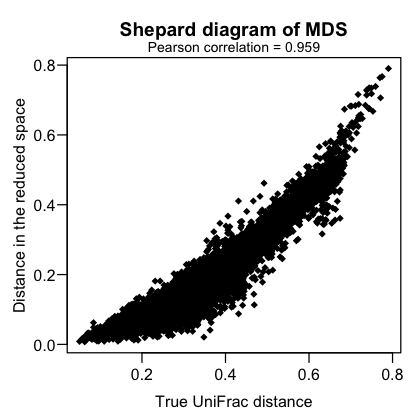

In [14]:
set.seed(100)
wUF.nmds.3D = metaMDS(wunifrac_dist, method="NMDS", k=3, trymax=1000, trace=1)
swUF.nmds.3D = metaMDS(sub_wUF, method="NMDS", k=3, trymax=1000, trace=1)

options(repr.plot.width=3.5, repr.plot.height=3.5)
par(mfrow = c(1,1), mar = c(3.5,3.5,3,1), mgp = c(2, 0.6, 0), cex = 0.8, las = 1)
pears <- round(cor(sub_wUF, dist(swUF.nmds.3D$points), method = "pearson"),3)
plot(sub_wUF, dist(swUF.nmds.3D$points), main = "Shepard diagram of MDS", 
     xlab = "True UniFrac distance", ylab = "Distance in the reduced space", pch=18)
mtext(line = 0.1, text = paste0("Pearson correlation = ", pears), cex = 0.7)


1-Dim      2-Dim      3-Dim      4-Dim      5-Dim      6-Dim      7-Dim 
0.34219248 0.17264310 0.10023807 0.07443071 0.05793906 0.04555252 0.03680109

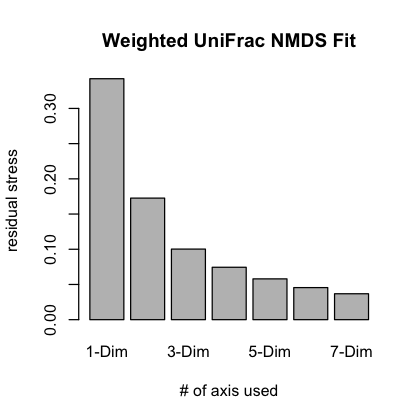

In [16]:
#n = 7
#stress <- rep(0, n)
#for (i in 1:n) {
#    stress[i] <- metaMDS(sub_wUF, trymax=1000, k = i, trace=0)$stress
#}
#names(stress) <- paste(1:n, "Dim", sep="-")
stress
par(cex=0.8)
barplot(stress, ylab = "residual stress", xlab='# of axis used')
title('Weighted UniFrac NMDS Fit')

In [34]:
bc_opt_vars = c('anti_day_length', 'SALINITY', 'TP', 'day_length', 'NO3F', 'DO')
wuf_opt_vars = c("WTEMP", "DO", "SALINITY", "TP", "julian_day", "NO3F", "day_length")
all_opt = unique(c(bc_opt_vars, wuf_opt_vars))

ENV.mini.3 = ENV.mini.2[,all_opt]

fit.swUF = envfit(swUF.nmds.3D, ENV.mini.3[,  c('TP', 'WTEMP', 'DO', 'anti_day_length')])
fit.swUF2 = envfit(swUF.nmds.3D, ENV.mini.3[, c('NO3F', 'SALINITY', 'anti_day_length', 'TP')], choices=c(3,2))
fit.swUF2


***VECTORS

                   NMDS3    NMDS2     r2 Pr(>r)    
NO3F             0.96385 -0.26644 0.3650  0.001 ***
SALINITY        -0.99702 -0.07720 0.7493  0.001 ***
anti_day_length -0.77526 -0.63164 0.1006  0.002 ** 
TP               0.49509 -0.86884 0.5031  0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Permutation: free
Number of permutations: 999



In [ ]:


wUNFxyz = scores(wUF.nmds.3D, display="sites")

plot(wUNFxyz[,1], wUNFxyz[,2], main="BC 1:2", pch=20)
plot(fit.wUF, add=T)
plot(wUNFxyz[,2], wUNFxyz[,3], main="BC 1:3", pch=20)
plot(fit.wUF2, add=T)

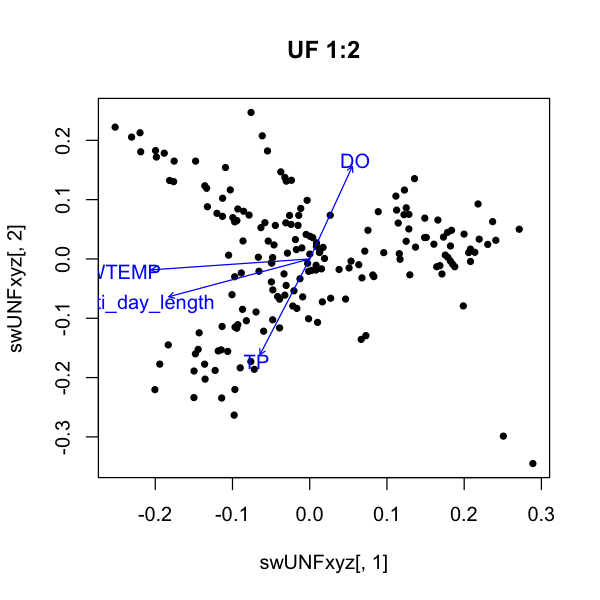

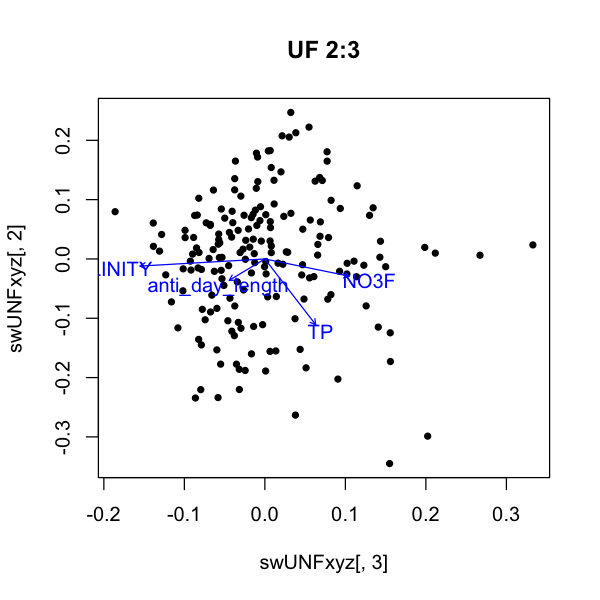

In [35]:
options(repr.plot.width=5, repr.plot.height=5)
swUNFxyz = scores(swUF.nmds.3D, display="sites")

plot(swUNFxyz[,1], swUNFxyz[,2], main="UF 1:2", pch=20)
plot(fit.swUF, add=T)
plot(swUNFxyz[,3], swUNFxyz[,2], main="UF 2:3", pch=20)
plot(fit.swUF2, add=T)

,NMDS1,NMDS2
TP,-0.1328805,-0.33282709
WTEMP,-0.4239669,-0.03789504
DO,0.1139337,0.32189149
anti_day_length,-0.3767315,-0.13156724


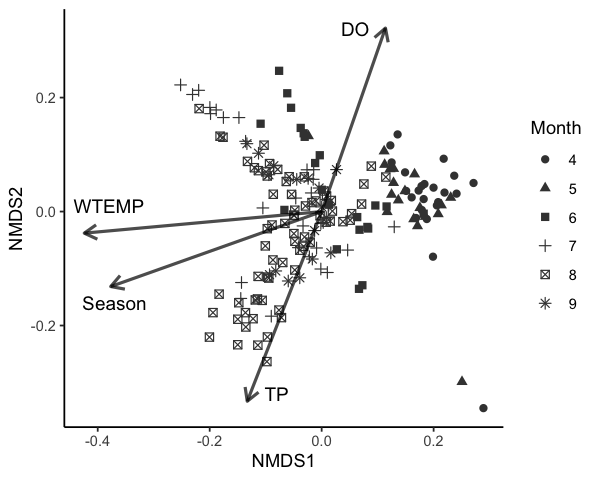

In [86]:
library(RColorBrewer)

mini.vectors.12 = c('TP', 'WTEMP', 'DO', 'anti_day_length')
mini.aes = c('Month', 'SALINITY')
plot.df.mini = cbind.data.frame(swUNFxyz, ENV.mini[,mini.aes])
colnames(plot.df.mini) <- c('NMDS1', 'NMDS2', 'NMDS3', 'Month', 'Salinity')

spp.scrs <- as.data.frame(scores(fit.swUF, display = "vectors"))
spp.scrs <- apply(spp.scrs, MARGIN=2, FUN=function(x) {x*0.5})
spp.scrs

options(repr.plot.width=5, repr.plot.height=4)
sp2<-ggplot(plot.df.mini, aes(x=NMDS1, y=NMDS2, shape=Month)) + theme_classic() + geom_point(size=2, color='grey25') + 
             annotate("segment", x = 0, xend = spp.scrs[,'NMDS1'],y = 0, yend = spp.scrs[,'NMDS2'], alpha=0.7,
                      colour = "black", size=0.9, arrow=arrow(length = unit(0.12, "inches"))) + 
              annotate('text', 
                       x= c(-0.08, -0.38, 0.06, -0.37), 
                       y= c(-0.32, 0.01, 0.32, -0.16), 
                       label=c('TP', 'WTEMP', 'DO', 'Season'),
                       color='black', alpha=1.0, size=4)
#             annotate("text", x = c(0.10, -0.08, -0.10, 0.13, 0.01), 
#                              y = c(-0.14, -0.15, -0.3328, 0.28, -0.19), 
#                              label = c('NO3', 'NO2', 'TP', 'DO', "WC-PC2"), 
#                      color='black', alpha=1.0, size=4)
sp2

,NMDS3,NMDS2
NO3F,0.17468337,-0.04828851
SALINITY,-0.25891963,-0.02004762
anti_day_length,-0.07376987,-0.06010346
TP,0.10534929,-0.18487913


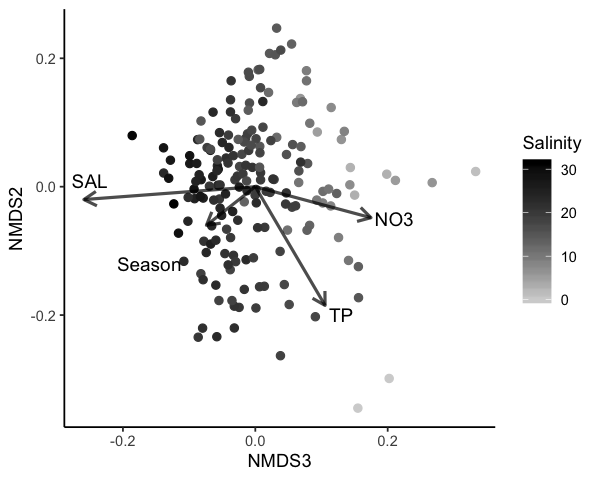

In [65]:
mini.vectors.13 = c('NO3F', 'SALINITY', 'anti_day_length', 'TP')
spp.scrs <- as.data.frame(scores(fit.swUF2, display = "vectors"))
spp.scrs <- apply(spp.scrs, MARGIN=2, FUN=function(x) {x*0.3})
spp.scrs


sp3 <-ggplot(plot.df.mini, aes(x=NMDS3, y=NMDS2, color=Salinity)) + theme_classic() + 
              geom_point(size=2) + scale_colour_gradient(low = "lightgrey", high = "black") +
             annotate("segment", x = 0, xend = spp.scrs[,'NMDS3'],y = 0, yend = spp.scrs[,'NMDS2'], 
                      alpha=0.7, colour = "black", size=0.9, arrow=arrow(length = unit(0.12, "inches"))) + 
             annotate("text", x = c(.21, -0.25, -0.16, 0.13), 
                              y = c(-0.05, 0.01, -0.12, -0.2), 
                             label = c('NO3', 'SAL', "Season", 'TP'), 
                             color='black', size=4)
sp3



In [ ]:
nti_fn = "../otu_data/dispersal_selection_data/ses_nti.RData"
load(nti_fn)
bnti_df = mntd_scores$comdistnt.obs.z[incl_samps, incl_samps]
bnti_dist = as.dist(bnti_df)

In [ ]:
ps.rarefied = rarefy_even_depth(ps, rngseed=1, sample.size=0.9*min(sample_sums(ps)), replace=F)

In [ ]:
BC.nmds.3D = metaMDS(OTU.clean2, distance="bray", k=3, trymax=1000)

In [ ]:
OTU.UF = otu_table(as.matrix(OTU.clean), taxa_are_rows=FALSE)
tax.UF = tax_table(as.matrix(tax.clean))
meta.UF = sample_data(meta)
wUF.dist = UniFrac(physeq.tree, weighted=TRUE, normalized=TRUE)
BC.nmds

In [ ]:
BC.nmds = metaMDS(OTU.clean, distance="bray", k=2, trymax=1000)
fit.BC = envfit(BC.nmds, meta[,c("AgeGroup", "ADGKG")])
fit.BC.OTU = envfit(BC.nmds, OTU.clean[,1:10])

In [ ]:
adonis(BC.dist ~ AgeGroup*ADGKG, data = meta, permutations = 1000)
adonis(uwUF.dist ~ AgeGroup*ADGKG, data=meta, permutations = 1000)
permutest(disp.age, pairwise=TRUE, permutations=1000)
simper(OTU.clean, meta$AgeGroup, permutations=100)
kruskal.test(OTU.clean$Otu00001 ~ meta$AgeGroup)
#Note: These P-values have not been corrected from false discovery rate (fdr) yet.



In [ ]:

KW.results = data.frame(read.csv("Age_krusk_simper.csv"))
#Remove non-significant
KW.results.signif = KW.results[KW.results$fdr_krusk_p.val < 0.05,]
#Order by OTU#
KW.results.signif = KW.results.signif[with(KW.results.signif, order(OTU)),]
head(KW.results.signif)